In [208]:
import torch
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, TensorDataset
from contextlib import contextmanager
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score


cuda = torch.device("cuda")
cpu = torch.device("cpu")
dev = cpu #cuda if torch.cuda.is_available() else cpu

@contextmanager
def switch_to_cpu(model):
    global dev
    _dev = dev
    dev = cpu
    model.to(cpu)
    yield
    dev = _dev
    model.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

# The following is adapted from:
# https://pytorch.org/tutorials/beginner/nn_tutorial.html

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
    
def get_model(n_classes=10):
    return nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, n_classes, kernel_size=3, stride=2, padding=1),
        nn.AdaptiveMaxPool2d(1),
        Lambda(lambda x: x.view(x.size(0), -1)),
    )


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def predict_batch(model, data_loader):
    reals = []
    preds = []
    for xb, yb in data_loader:
        reals.append(yb)
        preds.append(model(xb).argmax(dim=1))
        
    return (torch.cat(reals, 0), torch.cat(preds, 0))

def accuracy(model, data_loader):
    return accuracy_score(*predict_batch(model, data_loader))


def loss(model, loss_func, data_loader):
    losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in data_loader])
    return np.sum(np.multiply(losses, nums)) / np.sum(nums)

def fit(model, loss_func, opt, train_dl, *, valid_dl=None, max_epochs=20, threshold=1e-6, min_epochs=None):
    validation = valid_dl is not None
    print("Fitting a model...")
    last_loss = float("inf")
    epoch = 1
    accuracies = []
    losses = []
    while True:
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        
        with torch.no_grad(), switch_to_cpu(model):
            # print diagnostics about current epoch
            if validation:
                val_loss = loss(model, loss_func, valid_dl)
                val_acc = accuracy(model, valid_dl)
            train_loss = loss(model, loss_func, train_dl)
            train_acc = accuracy(model, train_dl)
        if validation:
            print("Epoch %s: val_loss=%s, train_loss=%s, val_acc=%s, train_acc=%s" % (epoch, val_loss, train_loss, val_acc, train_acc))
        else:
            print("Epoch %s: train_loss=%s, train_acc=%s" % (epoch, train_loss, train_acc))
        
        losses.append((val_loss, train_loss) if validation else train_loss)
        accuracies.append((val_acc, train_acc) if validation else train_acc)
        
        compare_loss = (val_loss if validation else train_loss)
        min_epochs_satisified = min_epochs is None or epoch >= min_epochs
        if threshold and last_loss - compare_loss < threshold and min_epochs_satisified:
            print("delta loss %s was lower than threshold %s, stopping" % (last_loss - compare_loss, threshold))
            break
        
        if max_epochs is not None and epoch >= max_epochs and min_epochs_satisified:
            print("Max epochs reached, stopping")
            break
        last_loss = compare_loss
        epoch += 1
    return losses, accuracies


def initer(layer):
    if type(layer) == nn.Conv2d:
        nn.init.kaiming_normal_(layer.weight)

# Train models
        
boots = [5, 7, 9]
not_boots = [i for i in range(10) if i not in boots]

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

def prep_ens(x, y):
    for i in range(10):
        y[y == i] = int(i in boots)
    return preprocess(x, y)

def prep_indexer(indexer):
    def prep(x, y):
        for i, k in enumerate(indexer):
            y[y == k] = i
        return preprocess(x, y)
    return prep

def get_dl(xs, ys, prep, bs=30):
    return WrappedDataLoader(DataLoader(TensorDataset(xs.type(torch.float32), ys), batch_size=bs), prep)

def get_dls(xs, ys, prep, bs=30):
    n = len(ys) * 3 // 10
    return {'train': get_dl(xs[:n], ys[:n], prep, bs), 'valid': get_dl(xs[n:], ys[n:], prep, bs)}

    

# torch.manual_seed_all(213742069)
torch.manual_seed(213742069)

torch.cuda.manual_seed_all(213742069)
torch.cuda.manual_seed(213742069)


train = FashionMNIST('.', download=True, train=True)

data_loaders = [get_dls(train.train_data, train.train_labels, prep_ens)]

mask_y = torch.stack([train.train_labels == i for i in boots]).max(dim=0)[0]
mask_x = mask_y.view(-1, 1, 1).repeat(1, 28, 28)

data_loaders.append(get_dls(train.train_data.masked_select(mask_x).view(-1, 28, 28), train.train_labels.masked_select(mask_y), prep_indexer(boots)))
mask_x, mask_y = 1 - mask_x, 1 - mask_y
data_loaders.append(get_dls(train.train_data.masked_select(mask_x).view(-1, 28, 28), train.train_labels.masked_select(mask_y), prep_indexer(not_boots)))

models = [get_model(2), get_model(3), get_model(7)]
min_epochs = [5, 20, 20]
max_epochs = [7, 25, None]
results = []
for model, dl, min_epoch, max_epoch in zip(models, data_loaders, min_epochs, max_epochs):
    model.to(dev)
    model.apply(initer)
    train_dl, valid_dl = (dl, None) if dl.__class__ == WrappedDataLoader else dl
    result = fit(
        model,
        F.cross_entropy,
        torch.optim.Adam(model.parameters()), 
        dl['train'], 
        valid_dl=dl['valid'], 
        max_epochs=50, 
#         min_epochs=min_epoch,
        threshold=None
    )
    results.append(result)
print("DONE!")

Fitting a model...
Epoch 1: val_loss=1.0344368247318112, train_loss=0.8794156223306459, val_acc=0.9555476190476191, train_acc=0.9577777777777777
Epoch 2: val_loss=0.49288899719594076, train_loss=0.36414773520960264, val_acc=0.9734285714285714, train_acc=0.9775
Epoch 3: val_loss=0.2578397615129039, train_loss=0.16732310818611681, val_acc=0.9850952380952381, train_acc=0.9872222222222222
Epoch 4: val_loss=0.17186575118834432, train_loss=0.09523741277884491, val_acc=0.9888809523809524, train_acc=0.9919444444444444
Epoch 5: val_loss=0.15614799948150165, train_loss=0.08492962403051292, val_acc=0.9883095238095239, train_acc=0.9919444444444444
Epoch 6: val_loss=0.1637641857750811, train_loss=0.06759528491843282, val_acc=0.9891190476190476, train_acc=0.9936666666666667
Epoch 7: val_loss=0.1434104542005408, train_loss=0.0692826376162337, val_acc=0.990547619047619, train_acc=0.9929444444444444
Epoch 8: val_loss=0.19219266986294173, train_loss=0.11334734991601704, val_acc=0.9872857142857143, train

Epoch 15: val_loss=0.707828721829823, train_loss=0.4396771266228623, val_acc=0.8038888888888889, train_acc=0.84
Epoch 16: val_loss=0.6877917957802614, train_loss=0.4015767566859722, val_acc=0.819047619047619, train_acc=0.8574074074074074
Epoch 17: val_loss=0.7515196925561343, train_loss=0.44014433585107327, val_acc=0.8257936507936507, train_acc=0.8579629629629629
Epoch 18: val_loss=0.7062230787106922, train_loss=0.435020539826817, val_acc=0.8128571428571428, train_acc=0.8483333333333334
Epoch 19: val_loss=0.7051110527699902, train_loss=0.45852493825885987, val_acc=0.8053968253968254, train_acc=0.8388888888888889
Epoch 20: val_loss=0.7311618208175614, train_loss=0.4046580866807037, val_acc=0.8295238095238096, train_acc=0.8637037037037038
Epoch 21: val_loss=0.6821210506771292, train_loss=0.38484277112616433, val_acc=0.8269841269841269, train_acc=0.8614814814814815
Epoch 22: val_loss=0.6960239709931471, train_loss=0.36115307855523293, val_acc=0.834047619047619, train_acc=0.868333333333333

Epoch 29: val_loss=0.7706904727281356, train_loss=0.6294603641898859, val_acc=0.7235034013605443, train_acc=0.7586507936507937
Epoch 30: val_loss=0.7741397552344264, train_loss=0.6239749331914243, val_acc=0.7234353741496599, train_acc=0.7619047619047619
Epoch 31: val_loss=0.7801741232069171, train_loss=0.6266242949380761, val_acc=0.7234353741496599, train_acc=0.7626190476190476
Epoch 32: val_loss=0.7741940452128041, train_loss=0.6149818818129245, val_acc=0.7245578231292517, train_acc=0.7647619047619048
Epoch 33: val_loss=0.7827662860556525, train_loss=0.6130115157436757, val_acc=0.7260204081632653, train_acc=0.763968253968254
Epoch 34: val_loss=0.7842323831453615, train_loss=0.6141835219448522, val_acc=0.7236054421768707, train_acc=0.7663492063492063
Epoch 35: val_loss=0.7765053597335912, train_loss=0.6057976564481145, val_acc=0.7245578231292517, train_acc=0.7638888888888888
Epoch 36: val_loss=0.7892627809120685, train_loss=0.6133583406252521, val_acc=0.7248299319727891, train_acc=0.76

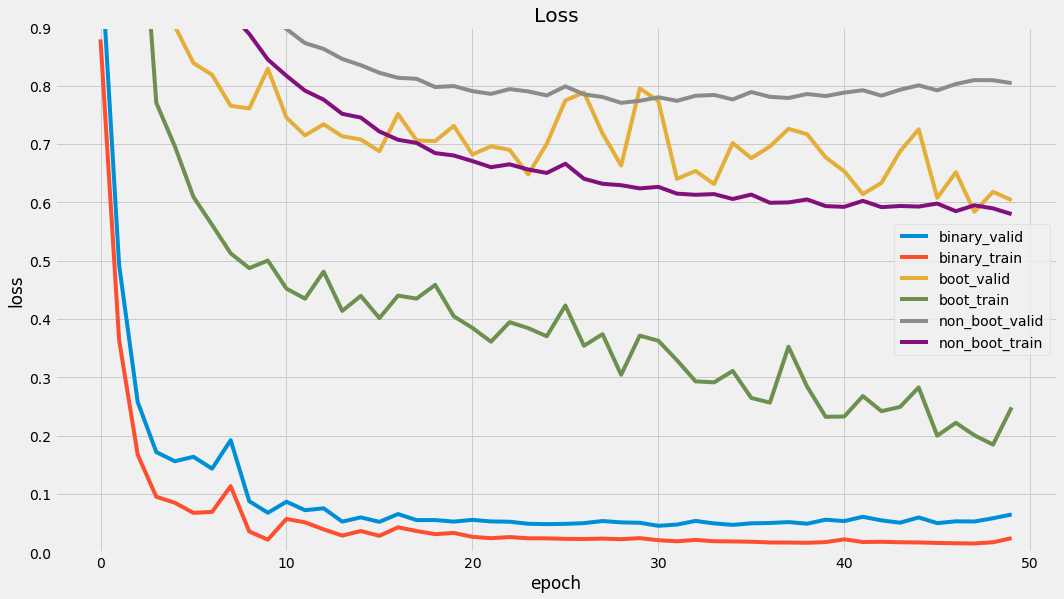

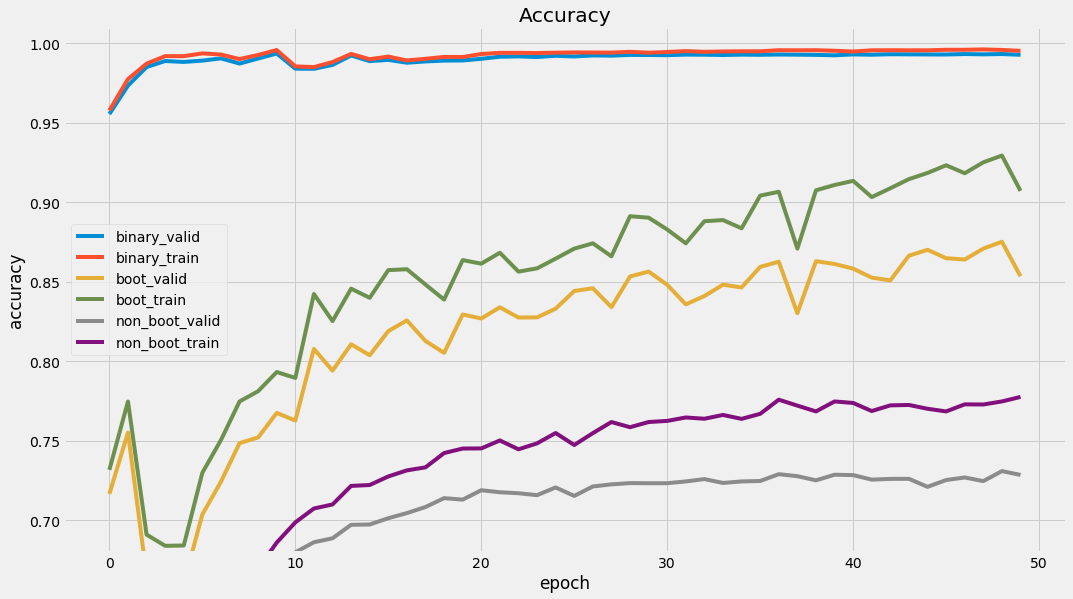

In [303]:
for i, (title, ylimits) in enumerate(zip(['Loss', 'Accuracy'], [(0., 0.9), (0.68, 1.01)])):
    plt.figure(figsize=(16, 9))
    for acc, label in zip(results[:, i], ['binary', 'boot', 'non_boot']):
        plt.plot(acc[:, 0], label=label + '_valid')
        plt.plot(acc[:, 1], label=label + '_train')
    plt.ylim(*ylimits)
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(title.lower())
    plt.legend()
    plt.show()

In [301]:
def predict(X):
    X1 = models[0](X)
    X1 = X1.argmax(dim=1)
    X2 = []
    for i, x in enumerate(X1):
#         print(X[i].size())
#         X2.append(models[2 - x](X[i].view(1, 1, 28, 28)).argmax(dim=1).item())
        val = models[2 - x](X[i].view(1, 1, 28, 28)).argmax(dim=1).item()
        X2.append(boots[val] if i == 1 else not_boots[val])
    return torch.tensor(X2)

test = FashionMNIST('.', download=True, train=False)
test_dl = get_dl(test.test_data, torch.ones(test.test_data.size(0)), preprocess, 10000)
preds = predict(next(iter(test_dl))[0])

preds.size(), preds

(torch.Size([10000]), tensor([2, 9, 1,  ..., 8, 1, 0]))

In [302]:
accuracy_score(preds, test.test_labels.numpy())

0.4985

In [205]:
def get_dls(xs, ys, prep, bs=30):
    n = len(ys) * 3 // 10
    return {'train': get_dl(xs[:n], ys[:n], prep, bs), 'valid': get_dl(xs[n:], ys[n:], prep, bs)}

get_dls(train.train_data, train.train_labels, prep_ens)

{'train': <__main__.WrappedDataLoader at 0x2ac3caac978>,
 'valid': <__main__.WrappedDataLoader at 0x2ac1a248518>}

In [297]:
results_[0].shape

(50, 2)

In [288]:
results = Out[i]

In [279]:
test = FashionMNIST('.', download=True, train=False)
test_dl = get_dl(test.test_data, torch.ones(test.test_data.size(0)), 10000)
preds = model(next(iter(test_dl))[0])
preds = preds.argmax(dim=1)
import pandas as pd
df = pd.DataFrame()
df['Class'] = preds
df.index.name = 'Id'
df.to_csv('submission.csv')
df

In [ ]:
import torch
from skorch import NeuralNetClassifier
net_regr = NeuralNetClassifier(
    module=get_model,
    max_epochs=20,
    lr=1e-6,
    criterion=nn.CrossEntropyLoss,
#     criterion__weight=weight,
    optimizer=torch.optim.Adam,
#     device='cuda',  # uncomment this to train with CUDA
)
X, y = next(iter(get_dl(train.train_data, train.train_labels, preprocess, bs=100000)))
net_regr.fit(X, y)